In [17]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
import os
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import datasets, linear_model, metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, r2_score
from sklearn.model_selection import train_test_split
from sklearnex import patch_sklearn

pd.set_option('display.max_colwidth', None)

np.random.seed(0)

In [18]:
from joblib import dump,load

reg = load('PHONE1flowSense.joblib')

In [20]:
data_dir = Path("./Comparing") 
df1 = pd.read_csv(data_dir / "fftStylo3.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df2 = pd.read_csv(data_dir / "fftStylo4.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df2 = df2[df2['frequency'] != "clocktime"]
df2 = df2.dropna()

df3 = pd.read_csv(data_dir / "fftREG.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df3 = df3[df3['frequency'] != "clocktime"]
df3 = df3.dropna()

In [21]:
def convert(df: pd.DataFrame, frame_size=10):
    x = np.asarray(df.iloc[:, 1]).reshape(-1, frame_size)
#     x = x[x.shape[0]//10:-x.shape[0]//10]
    return x

In [22]:
data1 = convert(df1)
data1.shape
data1[17184]

array([ 86.    , 107.8215,  42.1896,  14.0655,  19.6977,  25.8532,
        14.0014,  16.1335,  14.    ,  15.92  ])

In [23]:
data2 = convert(df2)
data2.shape
data2[548]

array([146.    , 108.7136,  11.095 ,  18.6447,  34.9285,  30.9888,
        24.9179,  13.0166,  18.    ,   5.15  ])

In [25]:
data3 = convert(df3)
data2.shape
data3[548]

array([46.     , 13.7376 , 25.0939 , 21.2635 , 12.1655 ,  7.4123 ,
       17.038  ,  4.9193 ,  2.     ,  5.34873])

In [26]:
X1 = data1[17183:,:-1]

X1 = X1[:, :9]
X1.shape

(3000, 9)

In [27]:
X2 = data2[547:,:-1]

X2 = X2[:, :9]
X2.shape

(3000, 9)

In [9]:
y = data2[547:, -1] #groundtruth
y.shape

(3000,)

In [10]:
y1 = data1[17183:, -1]
y1.shape

(3000,)

In [11]:
indices = np.random.choice(np.arange(y.shape[0]), size=100, replace=False, p=None)
logged_preds = []
predictions1 = []
predictions2 = []
groundtruth = []

In [12]:
for i in indices:
    #predictions1.append(y1[i])
    logged_preds.append(y1[i])
    predictions1.append(reg.predict(X1[i].reshape(1,-1)))
    predictions2.append(reg.predict(X2[i].reshape(1,-1)))
    groundtruth.append(y[i])

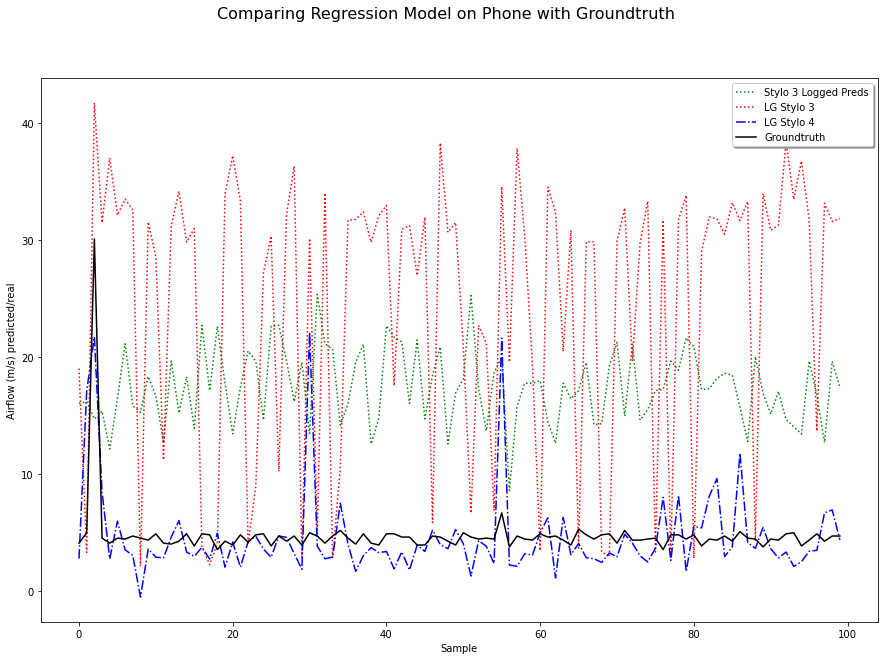

In [13]:
fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Comparing Regression Model on Phone with Groundtruth', fontsize=16)
l0, = ax1.plot(logged_preds, 'g:')
l1, = ax1.plot(predictions1, 'r:')
l2, = ax1.plot(predictions2, 'b-.')
l3, = ax1.plot(groundtruth, 'k-')
ax1.legend((l0, l1, l2, l3), ('Stylo 3 Logged Preds', 'LG Stylo 3', 'LG Stylo 4', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.savefig("comparing_with_groundtruth" , facecolor='w', transparent=False)
plt.show()

In [14]:
logged_mse = mean_squared_error(logged_preds, groundtruth)
stylo3_mse = mean_squared_error(predictions1, groundtruth)
stylo4_mse = mean_squared_error(predictions2, groundtruth)

print("Logged Predictions on Phone", logged_mse)
print("LG Stylo 3 FFT Values", stylo3_mse)
print("LG Stylo 4 FFT Values", stylo4_mse)

Logged Predictions on Phone 179.349757395804
LG Stylo 3 FFT Values 534.4377262511208
LG Stylo 4 FFT Values 11.166538330854927


In [15]:
from pypmml import Model

model = Model.fromFile('flowSense.pmml')

In [125]:
X1[24]

array([ 34.    , 133.8134,  68.8478,  46.2282,  26.    ,  40.6139,
        30.2652,  18.4237,  26.    ])

In [127]:
reg.predict(X1[24].reshape(1,-1))

array([4.6529931])

In [130]:
model.predict(X1[24])

[9.431959963802296]

In [132]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pipeline_obj = Pipeline([("model",reg)])

from nyoka import skl_to_pmml

features = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8", "x9"]
skl_to_pmml(pipeline=pipeline_obj,col_names=features,target_name="airflow",pmml_f_name="flowSense2.pmml")


/home/adam/miniconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute n_classes_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [133]:
from pypmml import Model

model = Model.fromFile('flowSense2.pmml')

In [134]:
model.predict(X1[24])

[4.652989174838566]

In [135]:
data_dir = Path("./50cm") 
df1 = pd.read_csv(data_dir / "fft_50_0_Vent1_0.txt", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

In [136]:
data = convert(df1)
data.shape

(372785, 10)

In [137]:
X = data[:,1:-1]

X = X[:, :9]
X.shape

(372785, 9)

In [138]:
y = data[:, -1]
y.shape

(372785,)

In [144]:
y_hat = reg.predict(X)
score = reg.score(X, y)

In [145]:
print(mean_squared_error(y_hat, y))

94.71179264669729
-226.61959495902363


In [146]:
indices = np.random.choice(np.arange(y.shape[0]), size=100, replace=False, p=None)
predictions = []
groundtruth = []

In [147]:
for i in indices:
    #predictions1.append(y1[i])
    predictions.append(y_hat[i])
    groundtruth.append(y[i])

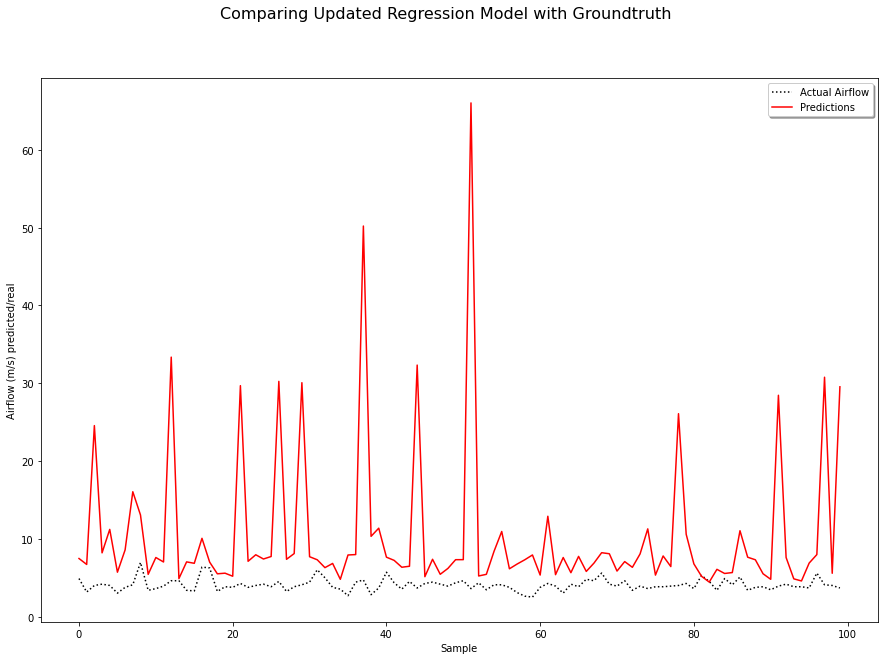

In [149]:
fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Comparing Updated Regression Model with Groundtruth', fontsize=16)
l0, = ax1.plot(groundtruth, 'k:')
l1, = ax1.plot(predictions, 'r-')
ax1.legend((l0, l1), ('Actual Airflow', 'Predictions'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

In [28]:
data3.shape

(6986, 10)

In [29]:
X = data3[:,:-1]

X = X[:, :9]
X.shape

(6986, 9)

In [30]:
y = data3[:, -1]
y.shape

(6986,)

In [31]:
predictions = reg.predict(X)
logged_preds = y

In [32]:
mean_squared_error(predictions, logged_preds)

51.05858672973838

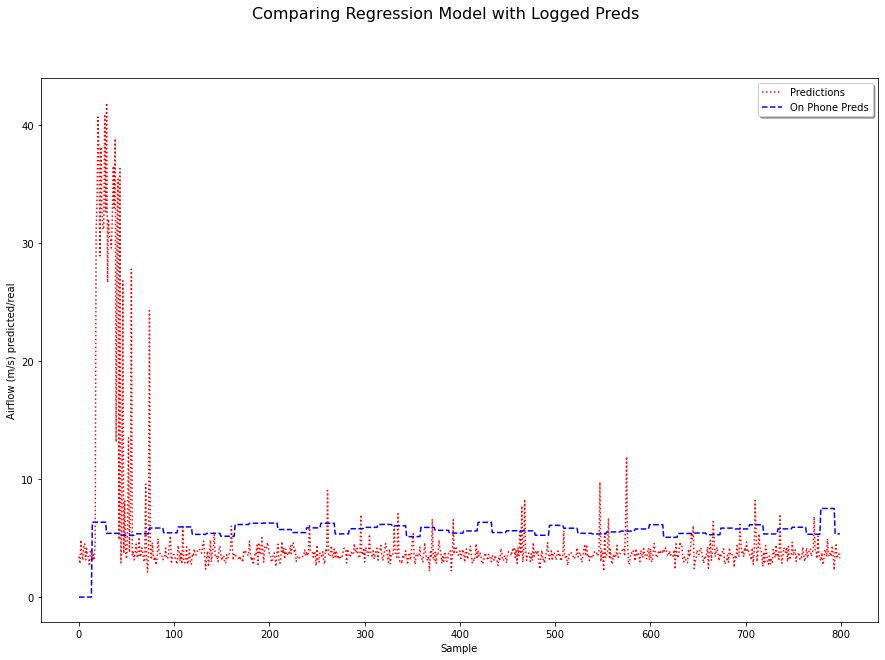

In [39]:
fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Comparing Regression Model with Logged Preds', fontsize=16)
l0, = ax1.plot(predictions[:800], 'r:')
l1, = ax1.plot(logged_preds[:800], 'b--')
ax1.legend((l0, l1), ('Predictions', 'On Phone Preds'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()